In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from __future__ import division

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import lal
from lal import CachedDetectors
from lal import LALDetectorIndexLHODIFF,LALDetectorIndexLLODIFF,LALDetectorIndexVIRGODIFF, LALDetectorIndexKAGRADIFF, LALDetectorIndexLIODIFF

from lal import ComputeDetAMResponse

import lalsimulation

DETECTOR_SITES = {
    'H1': LALDetectorIndexLHODIFF,
    'L1': LALDetectorIndexLLODIFF,
    'V1': LALDetectorIndexVIRGODIFF,
    'K1': LALDetectorIndexKAGRADIFF,
    'I1': LALDetectorIndexLIODIFF
    }
#resolution of skymap
n = 1000

In [2]:
# Calculate first the diagonal elements of kappa with the fitted PSDs of the data 
freqs = np.arange(20000)/10. + 20

#analytic fits of the PSDs
S_L1 = (0.8e-22*(15./(0.08+freqs))**2)**2+0.67e-23**2+((freqs/2000.)*3.e-23)**2
S_H1 = (1e-22*(24./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*3.4e-23)**2
S_V1 = (1e-22*(35./(0.1+freqs))**2)**2+0.9e-23**2+((freqs/2000.)*15e-23)**2

integral_nom = np.zeros([len(freqs),3])
integral_nom[:,0] = freqs**(-7./3.)*S_H1**(-1.)
integral_nom[:,1] = freqs**(-7./3.)*S_L1**(-1.)
integral_nom[:,2] = freqs**(-7./3.)*S_V1**(-1.)

integral_denom = freqs**(-7/3)*(S_H1**(-1.)+S_L1**(-1.)+S_V1**(-1.))
                                
kappa = np.zeros(3)

for i in range(3):
    kappa[i] = (integral_nom[:,i].sum())/(integral_denom.sum())
    
"""
print kappa.sum()
print kappa[0]
print kappa[1]
print kappa[2]
""";

In [3]:
class Detector(object):
    """
    A Detector object characterises a gravitational wave (GW) interferometric detector
    """

    def __init__(self, detector):
        """
        detector  -- label string of the detector
        descriptor -- LAL descriptor
        location -- geographic location of the detector
        response -- response matrix

        """
        self.name = detector
        self.descriptor =  CachedDetectors[DETECTOR_SITES[detector]]
        self.location = lalsimulation.DetectorPrefixToLALDetector(detector).location
        self.response = lalsimulation.DetectorPrefixToLALDetector(detector).response
        
    def antenna_pattern(self, time_at_coalescence, RA, dec):
        """ Compute antenna response
        """
        
        gmst_rad = lal.GreenwichMeanSiderealTime(time_at_coalescence)
        fplus = []
        fcross = []
        for (RA_val, dec_val) in zip(RA, dec):
            fplus_val,fcross_val = ComputeDetAMResponse(self.descriptor.response,
                                    RA_val, dec_val, psi, gmst_rad)
            fplus.append(fplus_val)
            fcross.append(fcross_val)
        return np.array(fplus), np.array(fcross)

In [4]:
def generateAntennaPatterns(time_0, ra_plot, dec_plot):
    #map resolution

    #time_GW170817 = 1187008882.43

    #time_0 = 1187007040.+256

    time = time_0

    #Generate Grid for the calculation
    ra, dec = np.meshgrid(ra_plot,dec_plot)

    for i in range(3):    
        if(i==0):
            detector = Detector('H1')
        if(i==1):
            detector = Detector('L1')
        if(i==2):
            detector = Detector('V1')

        Fplus,Fcross = detector.antenna_pattern(time, ra.flatten(), dec.flatten())

        if(i==0):
            FplusH1 = Fplus.reshape(ra.shape)
            FcrossH1 = Fcross.reshape(ra.shape)
        if(i==1):
            FplusL1 = Fplus.reshape(ra.shape)
            FcrossL1 = Fcross.reshape(ra.shape)
        if(i==2):
            FplusV1 = Fplus.reshape(ra.shape)
            FcrossV1 = Fcross.reshape(ra.shape)
            
    return FplusH1, FcrossH1, FplusL1, FcrossL1, FplusV1, FcrossV1
    

In [33]:
from numpy import linalg as LA
from numpy import unravel_index
import matplotlib.cm as cm 

psi = np.float(0)

time_0 = 1187007040. + 256.
ninj = 1

In [34]:
ra_plot = np.linspace(-np.pi, np.pi, n)
dec_plot= np.linspace(-np.pi/2, np.pi/2, n)

ra_mesh, dec_mesh = np.meshgrid(ra_plot,dec_plot)
    
def ThetaFunction(ra_plot, dec_plot):
    opt_event_pos = []
    ninj = 1
    n = len(ra_plot)
    for k in range(ninj):
        delta_t = 100
        time_0 = 1187007040. + 256.
        FplusH1, FcrossH1, FplusL1, FcrossL1, FplusV1, FcrossV1 = generateAntennaPatterns(time_0+k*delta_t, ra_plot,  dec_plot)

        Theta = np.zeros([2,2,n,n]) 
        Theta_diag = np.zeros([n,n])
        epsilon = np.zeros([n,n])
        sigma_d = np.zeros([n,n])

        index_phi = np.arange(n)
        index_theta = np.arange(n)

        for i in index_phi:
            for j in index_theta:
                Theta[0,0,j,i] = kappa[0]*FplusH1[j,i]**2 + kappa[1]*FplusL1[j,i]**2 + kappa[2]*FplusV1[j,i]**2
                Theta[0,1,j,i] = kappa[0]*FplusH1[j,i]*FcrossH1[j,i] + kappa[1]*FplusL1[j,i]*FcrossL1[j,i] + \
                                + kappa[2]*FplusV1[j,i]*FcrossV1[j,i]
                Theta[1,0,j,i] = Theta[0,1,j,i]
                Theta[1,1,j,i] = kappa[0]*FcrossH1[j,i]**2 + kappa[1]*FcrossL1[j,i]**2 + kappa[2]*FcrossV1[j,i]**2

                #calculate the eigenvalues
                e,_ = LA.eig(np.array(Theta[:,:,j,i]))
                epsilon[j,i] = (e[0]-e[1])/(e[0] + e[1])
                sigma_d[j,i] = 1/2*(e[0] + e[1])

        #identify where the detector network has the highest resolution 
        epsilon_abs = abs(epsilon)

        ind = unravel_index(epsilon_abs.argmin(), FplusH1.shape)
        #print ind

        ra_mesh, dec_mesh = np.meshgrid(ra_plot,dec_plot)
        #print('ra = {0} deg, dec = {1} deg'.format(ra_plot[ind[1]]*180/np.pi, 180/np.pi*dec_plot[ind[0]]))
        #print('Minimized epsilon: ra = {0}, dec = {1}'.format(ra_plot[ind[1]],dec_plot[ind[0]]))

        #where is the distance error the smallest
        ind2 = unravel_index((sigma_d*(1-epsilon**2)).argmax(), FplusH1.shape)

        #print('Maximal sigma_D*(1-epsilon^2): ra = {0}, dec = {1}'.format(ra_plot[ind2[1]],dec_plot[ind2[0]]))

        opt_event_pos.append(ra_plot[ind2[1]])
        opt_event_pos.append(dec_plot[ind2[0]])

    opt_event_pos = np.reshape(opt_event_pos,np.zeros([ninj,2]).shape)

    return epsilon_abs, opt_event_pos, sigma_d, Theta

In [35]:
epsilon_abs, opt_event_pos, sigma_d, Theta = ThetaFunction(ra_plot, dec_plot)

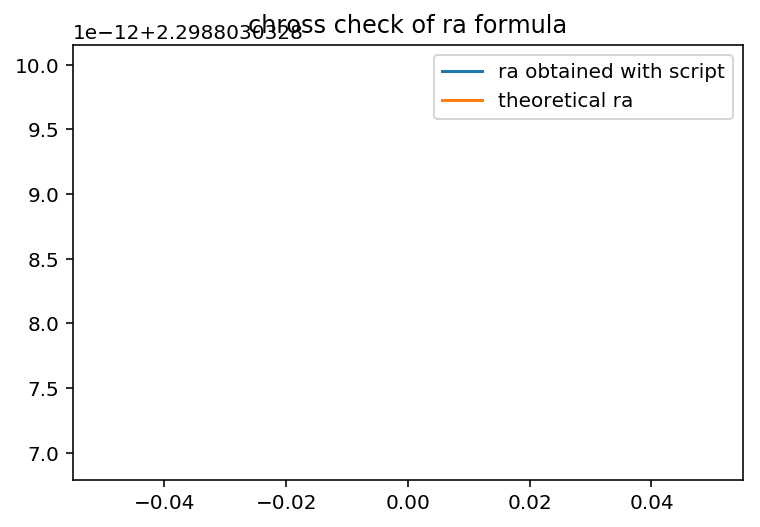

The resolution of the network is 0.00628318530718


In [8]:
#Calculate ra for different times, ra=ra_0+2pi(t_measure-t_created)/t_siderealday
time_offset = 100*np.arange(ninj)
ra = 2.29880303281 + 2*np.pi*time_offset/(86164.09)

a = opt_event_pos.copy()

#mirror point if needed
for i in range(ninj):
    if(a[i,0]<0):
        a[i,0] = a[i,0]+np.pi
        a[i,1] = - a[i,1]
        
plt.plot(a[:,0], label = 'ra obtained with script')
plt.plot(ra, label='theoretical ra')
plt.title('chross check of ra formula')
plt.legend()
plt.show()
print("The resolution of the network is {0}".format(2*np.pi/n))

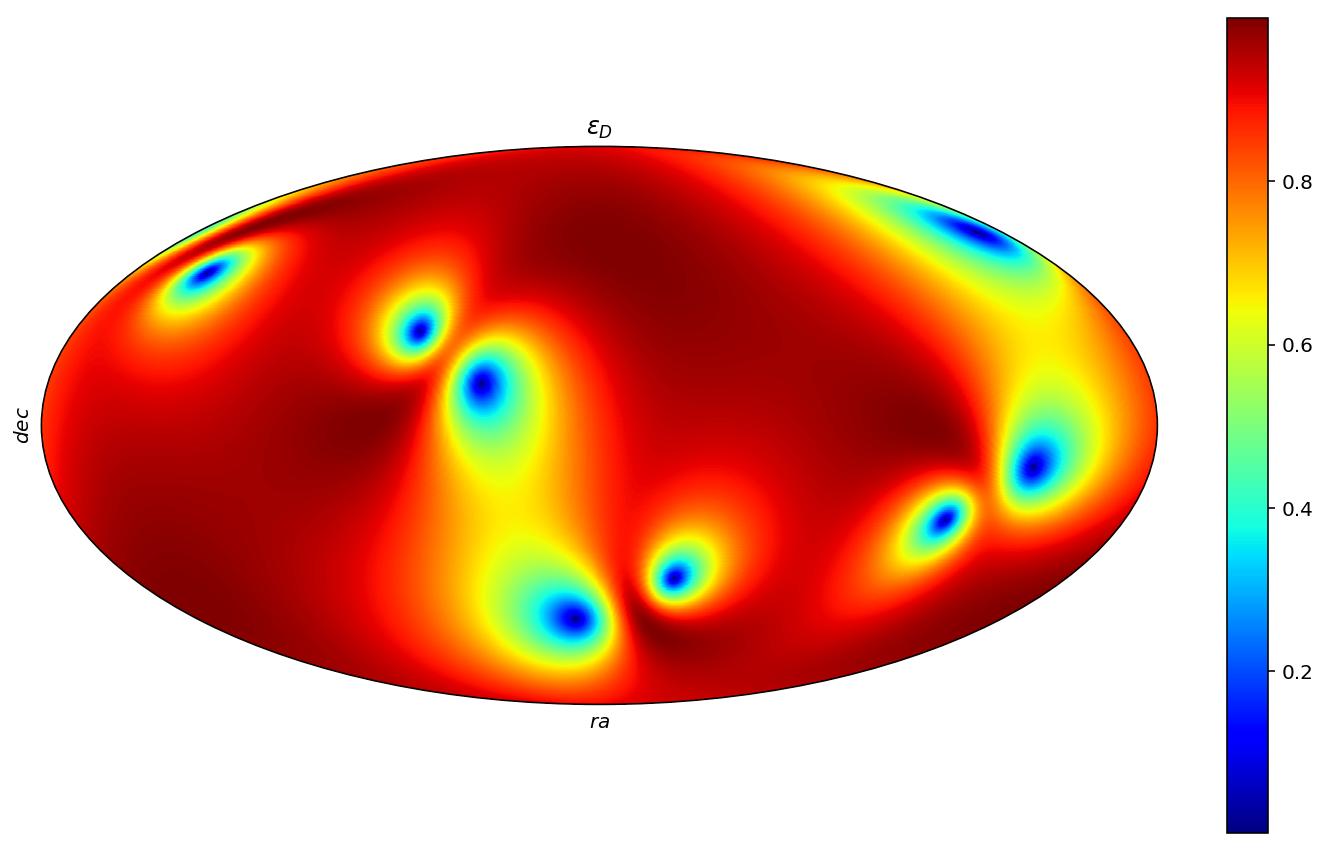

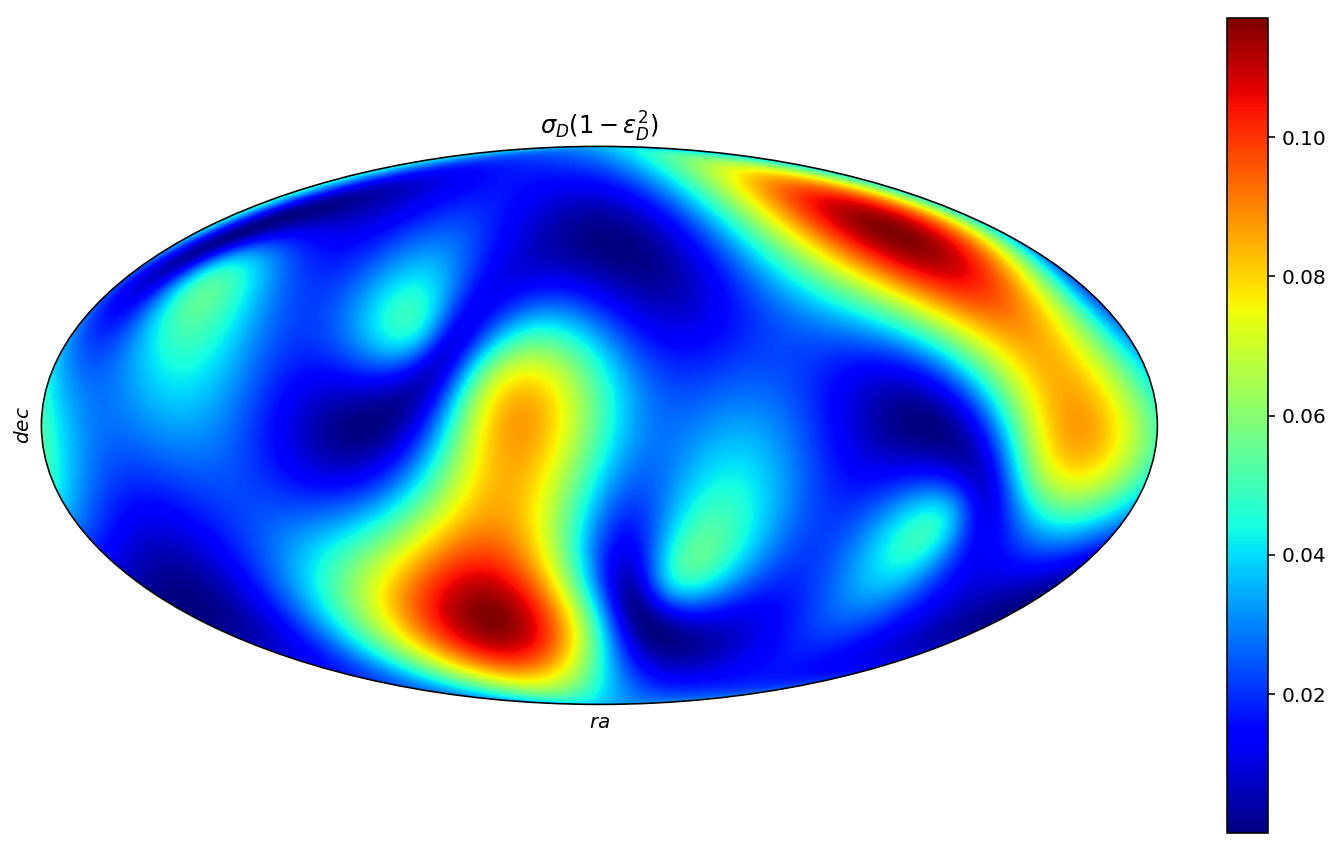

In [9]:
ra_mesh, dec_mesh = np.meshgrid(ra_plot,dec_plot)
FplusH1, FcrossH1, FplusL1, FcrossL1, FplusV1, FcrossV1 = generateAntennaPatterns(time_0, ra_plot,  dec_plot)

fig = plt.figure(1)
ax = fig.add_subplot(111, projection='mollweide')
fig.set_size_inches(12.5, 7.5)
plt.pcolormesh(ra_mesh, dec_mesh, epsilon_abs, cmap = cm.jet)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel('$ra$')
plt.ylabel('$dec$')
plt.title('$\epsilon_D$')
plt.show()

fig = plt.figure(2)
ax = fig.add_subplot(111, projection='mollweide')
fig.set_size_inches(12.5, 7.5)
plt.pcolormesh(ra_mesh, dec_mesh, sigma_d*(1-epsilon_abs**2), cmap = cm.jet)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.xlabel('$ra$')
plt.ylabel('$dec$')
plt.title('$\sigma_D(1-\epsilon_D^2)$')
plt.show()

In [10]:
#Find local maxima
def findlocalmin(xmin=0,xmax=1000,ymin=0,ymax=1000, plot=False):

    eps_segment = epsilon_abs[ymin:ymax,xmin:xmax]

    ind = unravel_index(eps_segment.argmin(), FplusH1[ymin:ymax,xmin:xmax].shape)
    #print ind
    ra_plot = np.linspace(-np.pi, np.pi, n)
    dec_plot= np.linspace(-np.pi/2, np.pi/2, n)
    ra_mesh, dec_mesh = np.meshgrid(ra_plot,dec_plot)
    ra_segment = ra_plot[xmin:xmax]
    dec_segment = dec_plot[ymin:ymax]
    #print('ra = {0} deg, dec = {1} deg'.format(ra_segment[ind[1]]*180/np.pi, 180/np.pi*dec_segment[ind[0]]))
    print('ra = {0}, dec = {1}'.format(ra_segment[ind[1]],dec_segment[ind[0]]))
    print('epsilon_D = {0}'.format(eps_segment[ind[0],ind[1]]))
    
    if(plot):
        #plot the segment
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='mollweide')
        fig.set_size_inches(8.5, 4.5)
        plt.pcolormesh(ra_mesh[ymin:ymax,xmin:xmax], dec_mesh[ymin:ymax,xmin:xmax], epsilon_abs[ymin:ymax,xmin:xmax], cmap = cm.jet)
        plt.grid()
        plt.xlabel('$ra$')
        plt.ylabel('$dec$')
        plt.show()
    return ra_segment[ind[1]],dec_segment[ind[0]]

ra = -2.63843467103, dec = 0.72171723123
epsilon_D = 0.0113855310717
ra = -1.07235545032, dec = 0.435546128651
epsilon_D = 0.003513610368
ra = -0.669829064279, dec = 0.190256612154
epsilon_D = 0.00240833659205
ra = -0.185539506068, dec = -0.935559373817
epsilon_D = 0.00224748766048


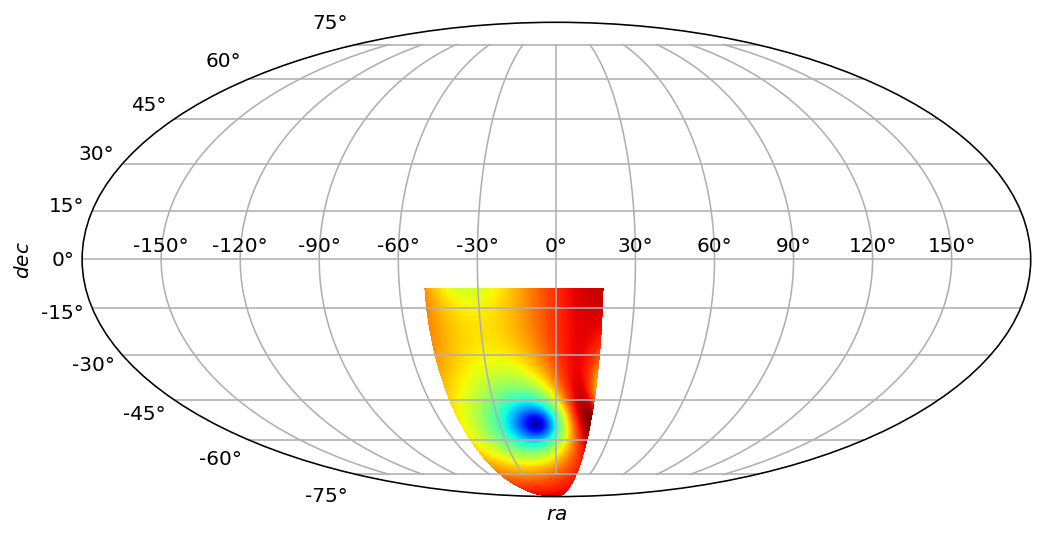

In [11]:
#Find local minima of epsilon_D
ra_min_epsilon = np.zeros(4)
dec_min_epsilon = np.zeros(4)

ra_min_epsilon[0], dec_min_epsilon[0] = findlocalmin(0,120,0,1000)
ra_min_epsilon[1], dec_min_epsilon[1] = findlocalmin(250,350,0,1000)
ra_min_epsilon[2], dec_min_epsilon[2] = findlocalmin(360,450,450,1000)
ra_min_epsilon[3], dec_min_epsilon[3] = findlocalmin(360,550,0,450,True)

1.50271190121


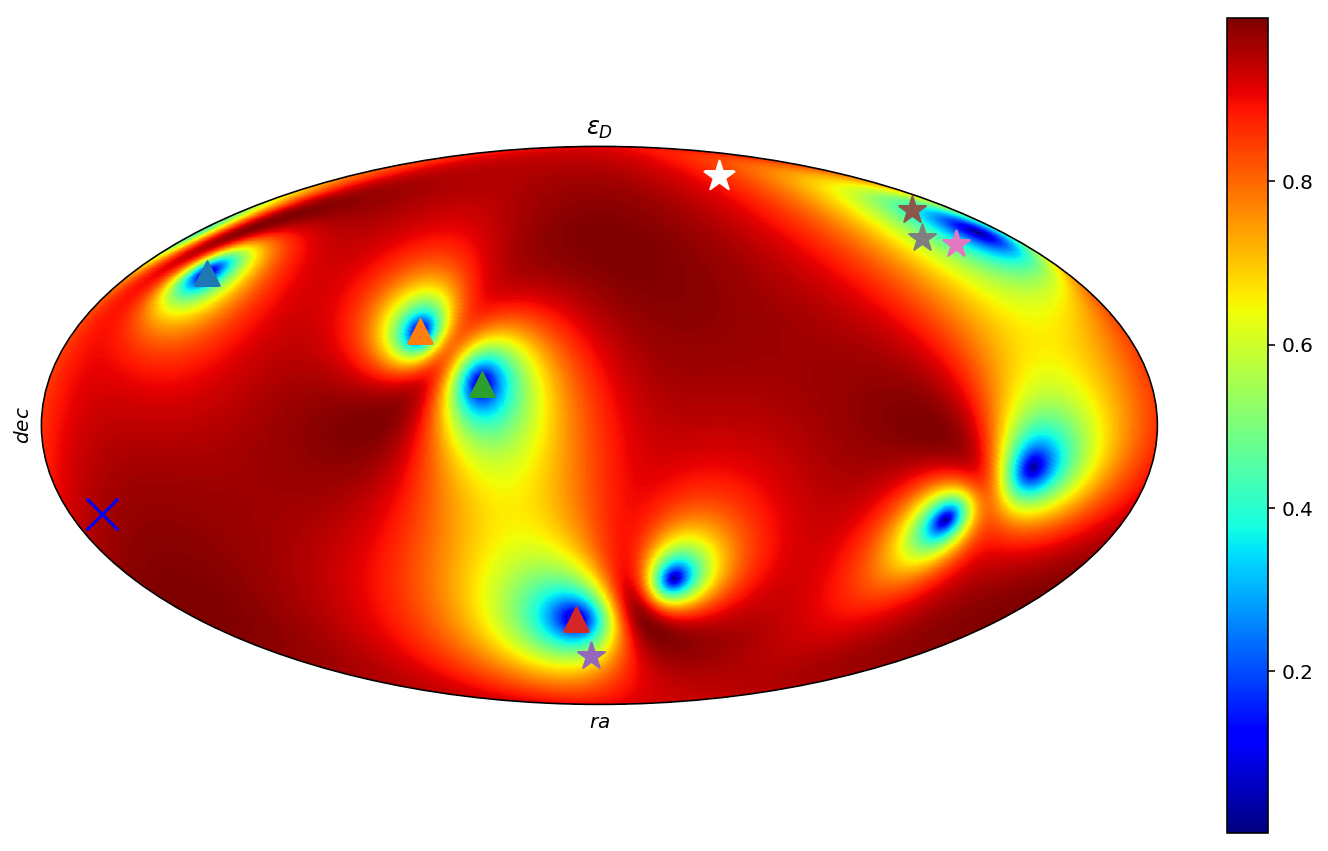

In [12]:
#Plot all the simulated points at time_0

fig = plt.figure(3)
ax = fig.add_subplot(111, projection='mollweide')
fig.set_size_inches(12.5, 7.5)
plt.pcolormesh(ra_mesh, dec_mesh, epsilon_abs, cmap = cm.jet)
plt.colorbar()

#real event
time_sid_day = 86164.09
event_time = 1187008882.43
realeventra = 3.44613122778 + 2*np.pi*(time_0-event_time)/time_sid_day - 2*np.pi
realeventdec = -0.406661715715
plt.scatter(realeventra, realeventdec, marker = 'x', s = 250, c='blue')
#ax.annotate('real event', (realeventra ,realeventdec))

#events to minimize epsilon_d
for i in range(4):
    plt.scatter(ra_min_epsilon[i], dec_min_epsilon[i], marker = '^', s = 150)

#events with xi
ra_xi_epsilon = [-0.08395106, 2.77204227, 2.64510923,2.45470968]
dec_xi_epsilon = [-1.15826395814,1.06306418076,0.872664625997,0.904397885124]

for i in range(4):
    xi_scatter = plt.scatter(ra_xi_epsilon[i], dec_xi_epsilon[i], marker = '*', s = 200)

#event with Fisher matrix iota = 170, for point see in script SkyPlotter
raFisher = 1.61839621549 + np.pi*2*(time_0-event_time)/time_sid_day
decFisher = 1.28519699465
Fisher = plt.scatter(raFisher,decFisher , marker = '*', s = 250, c='white')
print raFisher


    

plt.xticks([])
plt.yticks([])
plt.xlabel('$ra$')
plt.ylabel('$dec$')
plt.title('$\epsilon_D$')
plt.show()


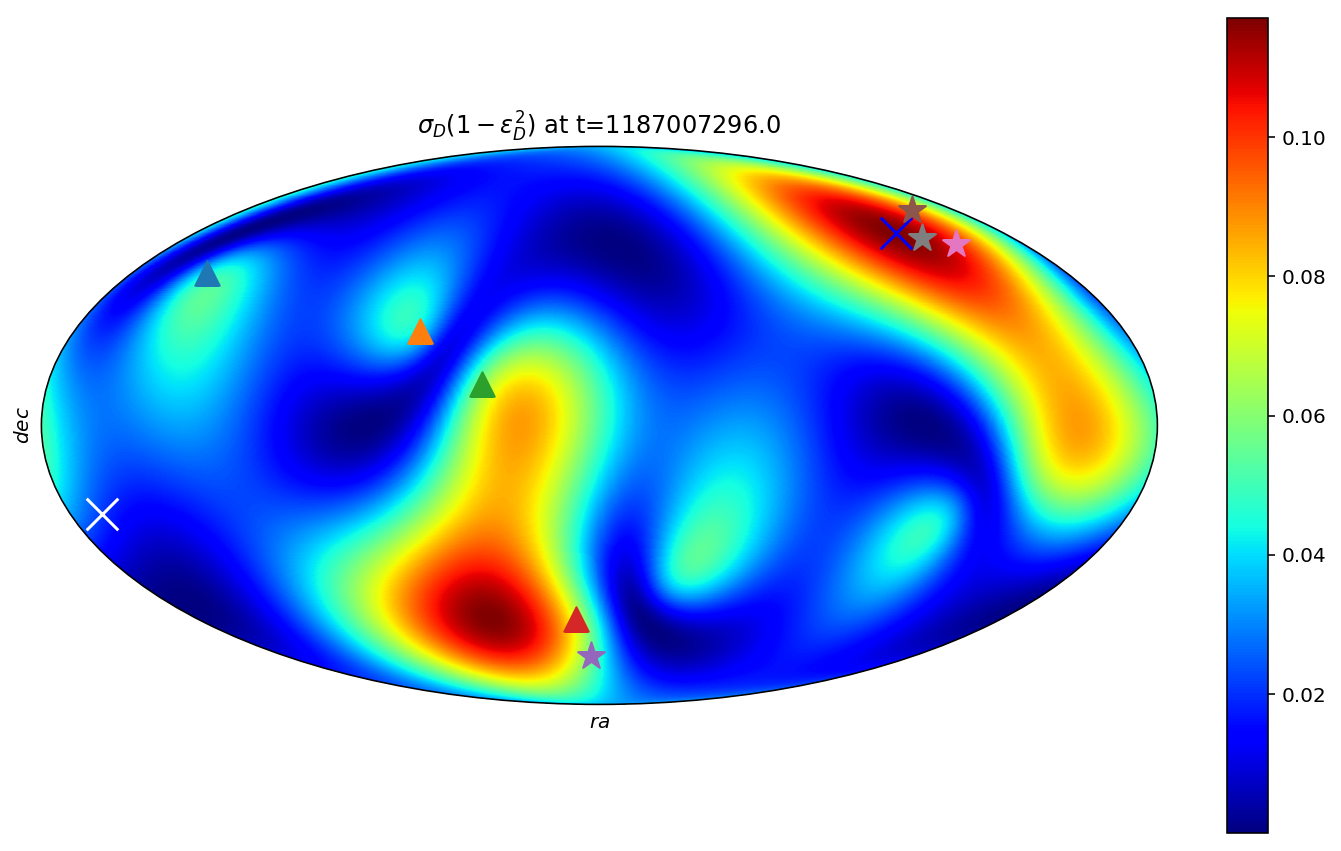

"\nfig = plt.figure(5)\nax = fig.add_subplot(111, projection='mollweide')\nfig.set_size_inches(12.5, 7.5)\nplt.pcolormesh(ra_mesh, dec_mesh, np.sqrt(FplusL1**2+FcrossL1**2) , cmap = cm.jet)\nplt.grid(color='black', linestyle=':', linewidth=0.3)\nax.set_xticklabels([])\nax.set_yticklabels([])\nplt.colorbar()\n\nfig = plt.figure(6)\nax = fig.add_subplot(111, projection='mollweide')\nfig.set_size_inches(12.5, 7.5)\nplt.pcolormesh(ra_mesh, dec_mesh, np.sqrt(FplusV1**2+FcrossV1**2) , cmap = cm.jet)\nplt.grid(color='black', linestyle=':', linewidth=0.3)\nax.set_xticklabels([])\nax.set_yticklabels([])\nplt.colorbar()\n"

In [13]:
fig = plt.figure(4)
ax = fig.add_subplot(111, projection='mollweide')
fig.set_size_inches(12.5, 7.5)
plt.pcolormesh(ra_mesh, dec_mesh, sigma_d*(1-epsilon_abs**2), cmap = cm.jet)
plt.colorbar()

#real event
time_sid_day = 86164.09
event_time = 1187008882.43
realeventra = 3.44613122778 + 2*np.pi*(time_0-event_time)/time_sid_day - 2*np.pi
realeventdec = -0.406661715715
plt.scatter(realeventra, realeventdec, marker = 'x', s = 250, c='white')

#Cutler and Flanagan, minimal distance error but not with SNR constant
plt.scatter(opt_event_pos[0,0], opt_event_pos[0,1], marker = 'x', s = 250, c='blue')

#events to minimize epsilon_d
for i in range(4):
    plt.scatter(ra_min_epsilon[i], dec_min_epsilon[i], marker = '^', s = 150)

#events with xi
ra_xi_epsilon = [-0.08395106, 2.77204227, 2.64510923,2.45470968]
dec_xi_epsilon = [-1.15826395814,1.06306418076,0.872664625997,0.904397885124]

for i in range(4):
    plt.scatter(ra_xi_epsilon[i], dec_xi_epsilon[i], marker = '*', s = 200)


plt.xticks([])
plt.yticks([])
plt.xlabel('$ra$')
plt.ylabel('$dec$')
plt.title('$\sigma_D(1-\epsilon_D^2)$ at t={}'.format(time_0))
plt.show()

'''
fig = plt.figure(5)
ax = fig.add_subplot(111, projection='mollweide')
fig.set_size_inches(12.5, 7.5)
plt.pcolormesh(ra_mesh, dec_mesh, np.sqrt(FplusL1**2+FcrossL1**2) , cmap = cm.jet)
plt.grid(color='black', linestyle=':', linewidth=0.3)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar()

fig = plt.figure(6)
ax = fig.add_subplot(111, projection='mollweide')
fig.set_size_inches(12.5, 7.5)
plt.pcolormesh(ra_mesh, dec_mesh, np.sqrt(FplusV1**2+FcrossV1**2) , cmap = cm.jet)
plt.grid(color='black', linestyle=':', linewidth=0.3)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar()
'''


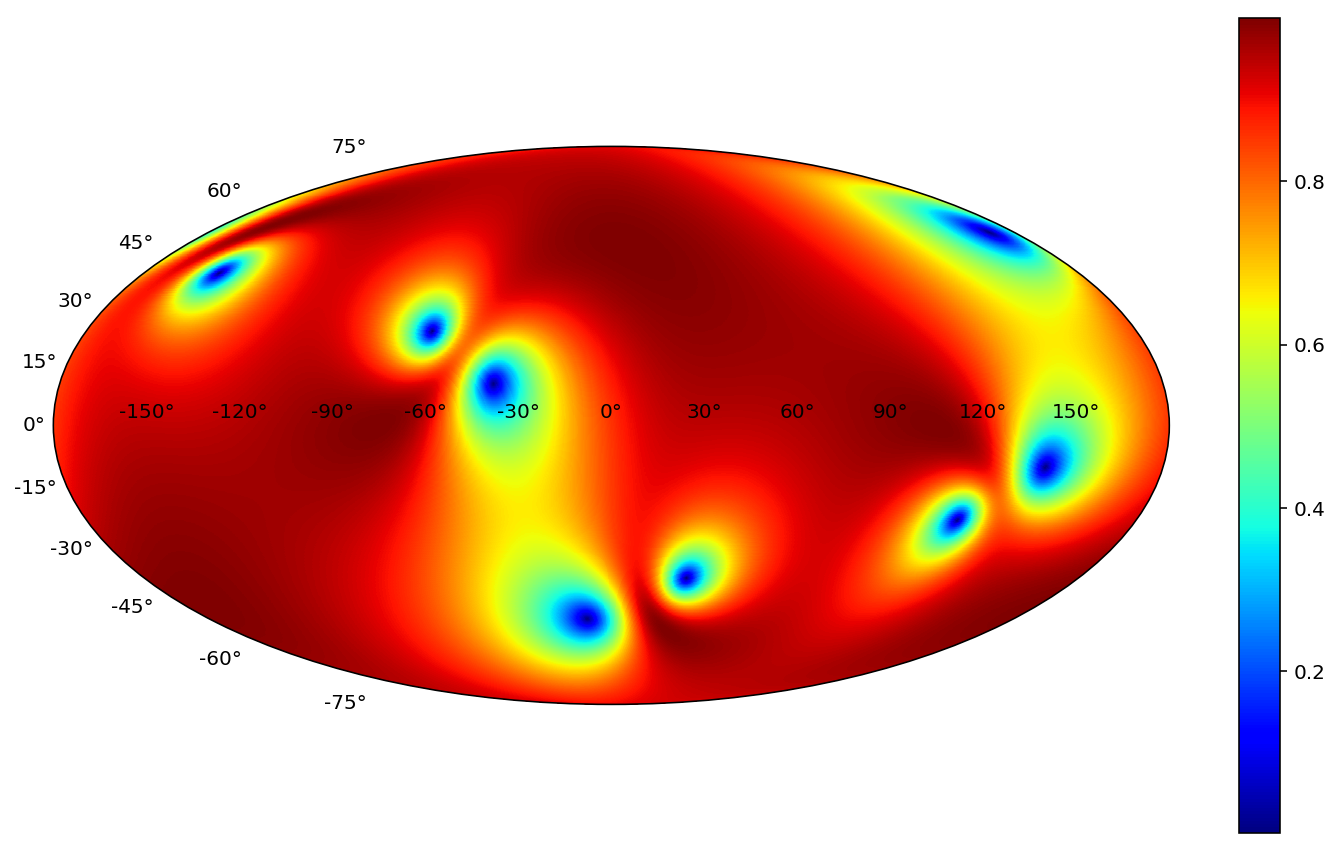

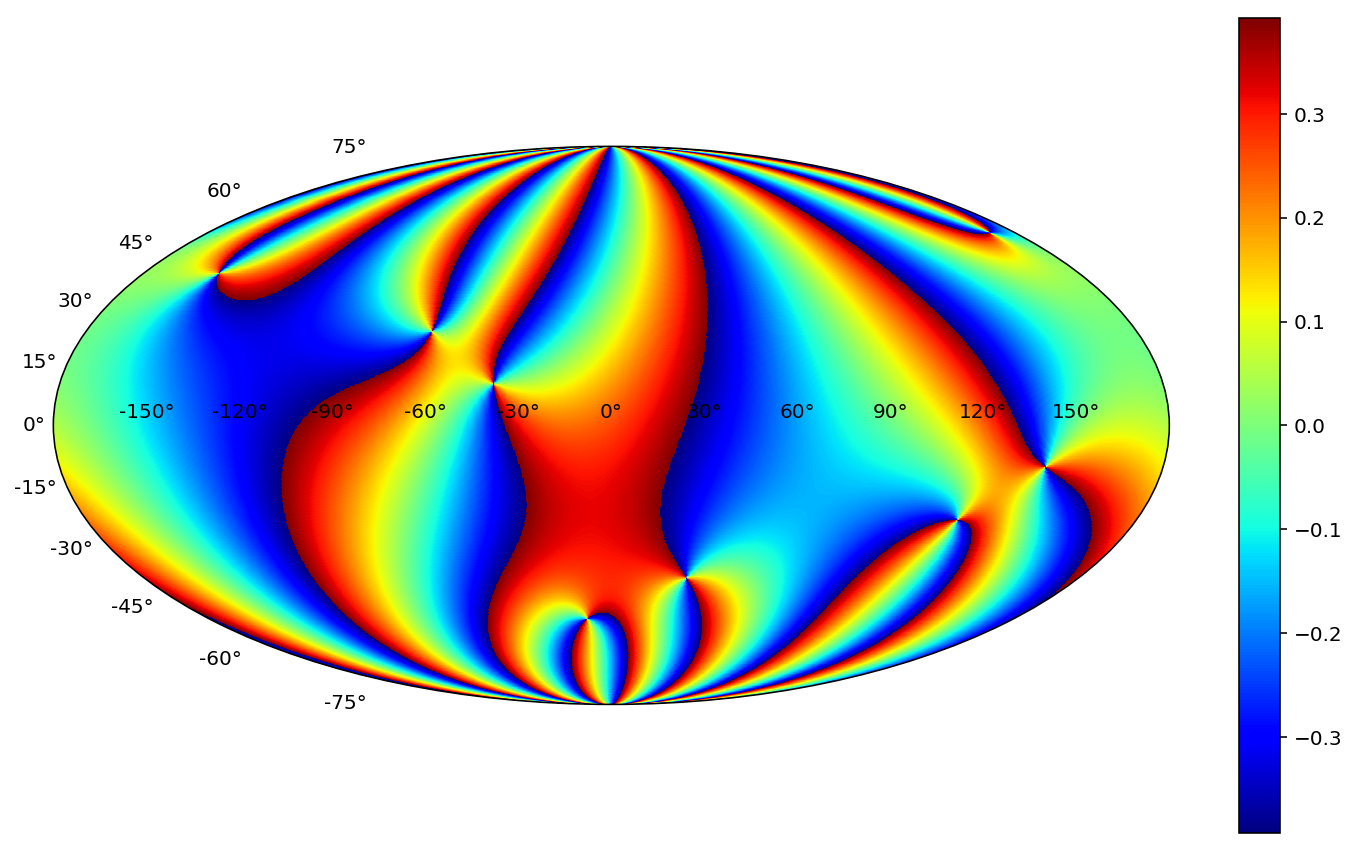

In [32]:
#Analytic expression for epsilon_D, which gives exactly the same plot

delta_psi = np.arctan(2*Theta[0,1]/(-Theta[1,1]+Theta[0,0]))/4.
c, s = np.cos(2*delta_psi), np.sin(2*delta_psi)
R = np.array([[c,s],[-s, c]])
Rtranspose = np.array([[c,-s],[s, c]])

ThetaDiag = np.zeros([2,2,n,n])

for i in range(n):
    for j in range(n):
        ThetaDiag[:,:,i,j] = np.dot(R[:,:,i,j],np.dot(Theta[:,:,i,j],Rtranspose[:,:,i,j]))

eps = (ThetaDiag[0,0,:,:]-ThetaDiag[1,1,:,:])/(ThetaDiag[0,0,:,:] + ThetaDiag[1,1,:,:])

fig = plt.figure(6)
ax = fig.add_subplot(111, projection='mollweide')
fig.set_size_inches(12.5, 7.5)
plt.pcolormesh(ra_mesh, dec_mesh, abs(eps), cmap = cm.jet)
plt.colorbar()
plt.show()

fig = plt.figure(7)
ax = fig.add_subplot(111, projection='mollweide')
fig.set_size_inches(12.5, 7.5)
plt.pcolormesh(ra_mesh, dec_mesh, delta_psi, cmap = cm.jet)
plt.colorbar()
plt.show()

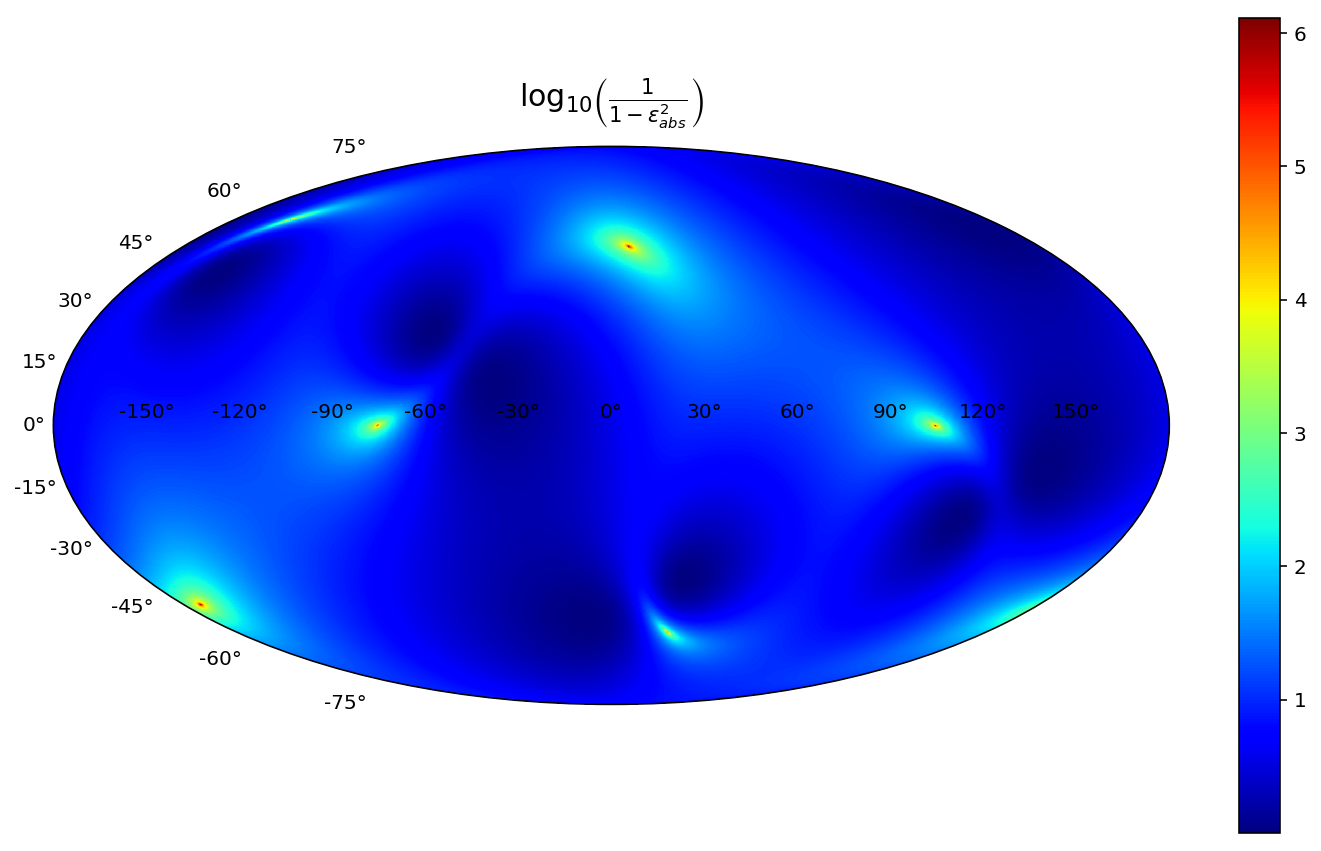

In [15]:
fig = plt.figure(7)
ax = fig.add_subplot(111, projection='mollweide')
fig.set_size_inches(12.5, 7.5)
plt.pcolormesh(ra_mesh, dec_mesh,np.log10(1/(1-epsilon_abs**2)), cmap = cm.jet)
plt.colorbar()
plt.title(r"$\log_{10} \left( \frac{1}{1-\epsilon_{abs}^2} \right)$", fontsize = 15, y = 1.05)
plt.show()

In [16]:
def f(eps_d):
    return(1/(1-eps_d**2))

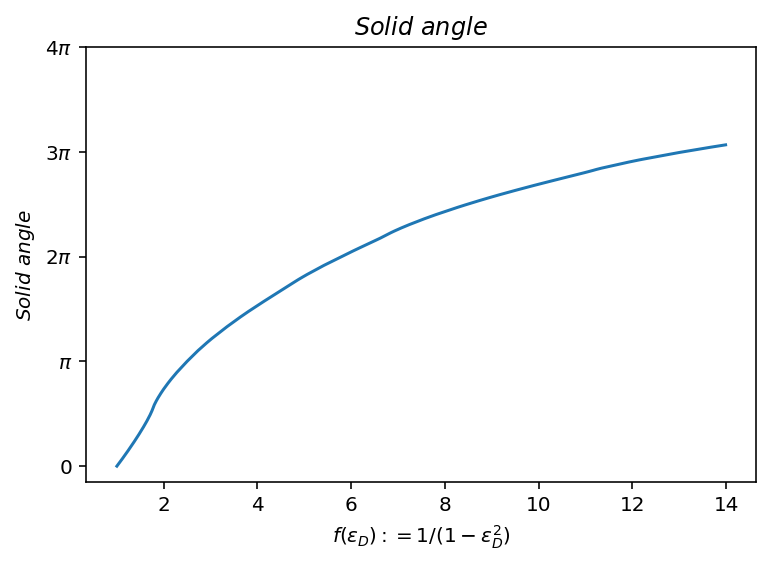

In [17]:
# Solid Angle of points with a distance error smaller of equal of f * minimial error on distance
f_map = f(epsilon_abs)
omega = []
range_cut = np.arange(1300)/100.+1
for f_0 in range_cut:
    
    f_map_cut = f_map.copy()
    index_above_cut = f_map_cut > f_0
    f_map_cut[index_above_cut] = 0
    n_under_cut_dec = len(index_above_cut) - np.sum(index_above_cut,1)

    omega_val = 4*np.pi*np.dot(n_under_cut_dec,np.cos(dec_plot))/(2*n**2/np.pi)
    omega.append(omega_val)

plt.plot(range_cut, omega)    
plt.xlabel('$f(\epsilon_D):=1/(1-\epsilon_D^2)$')
plt.ylabel('$Solid \ angle$')
plt.title('$Solid \ angle$')

y = np.arange(5)*np.pi
labels = [0,'$\pi$','$2\pi$','$3\pi$','$4\pi$']
plt.yticks(y, labels)
plt.show()

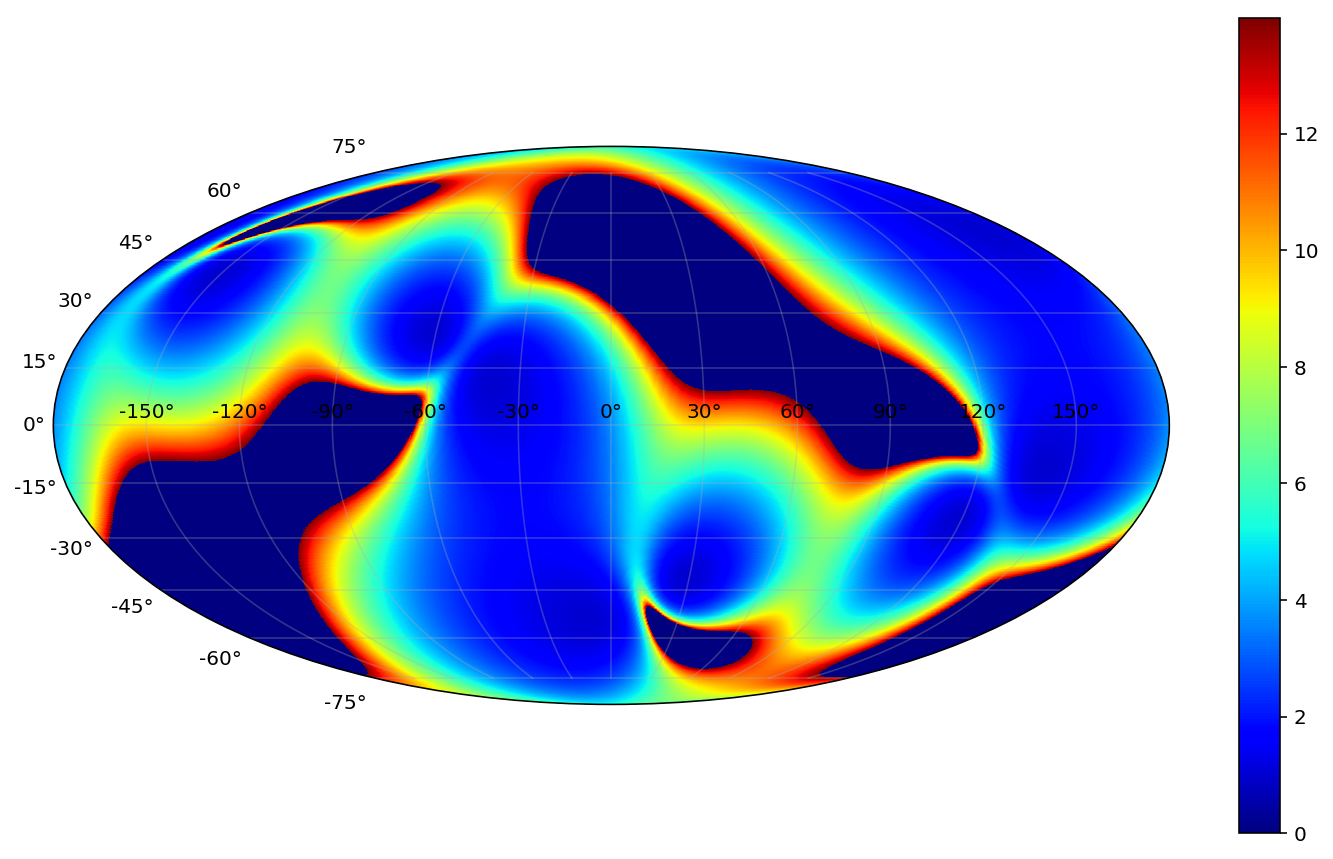

In [18]:
fig = plt.figure(8)
ax = fig.add_subplot(111, projection='mollweide')
fig.set_size_inches(12.5, 7.5)
plt.pcolormesh(ra_mesh, dec_mesh,f_map_cut, cmap = cm.jet)
plt.colorbar()
plt.grid(alpha=0.3)
plt.show()


In [19]:
eps_real_event,_,_,_ = ThetaFunction([realeventra],[realeventdec])
print eps_real_event

eps_Fisher,_,_,_ = ThetaFunction([raFisher],[decFisher])
print eps_Fisher

eps_xi = []
for i in range(4):
    eps,_,_,_ = ThetaFunction([ra_xi_epsilon[i]],[dec_xi_epsilon[i]])
    eps_xi.append(float(eps))

print eps_xi
    

[[ 0.96363979]]
[[ 0.86792211]]
[0.6022664841179015, 0.39167307152479697, 0.41507154227200654, 0.5421969818241742]


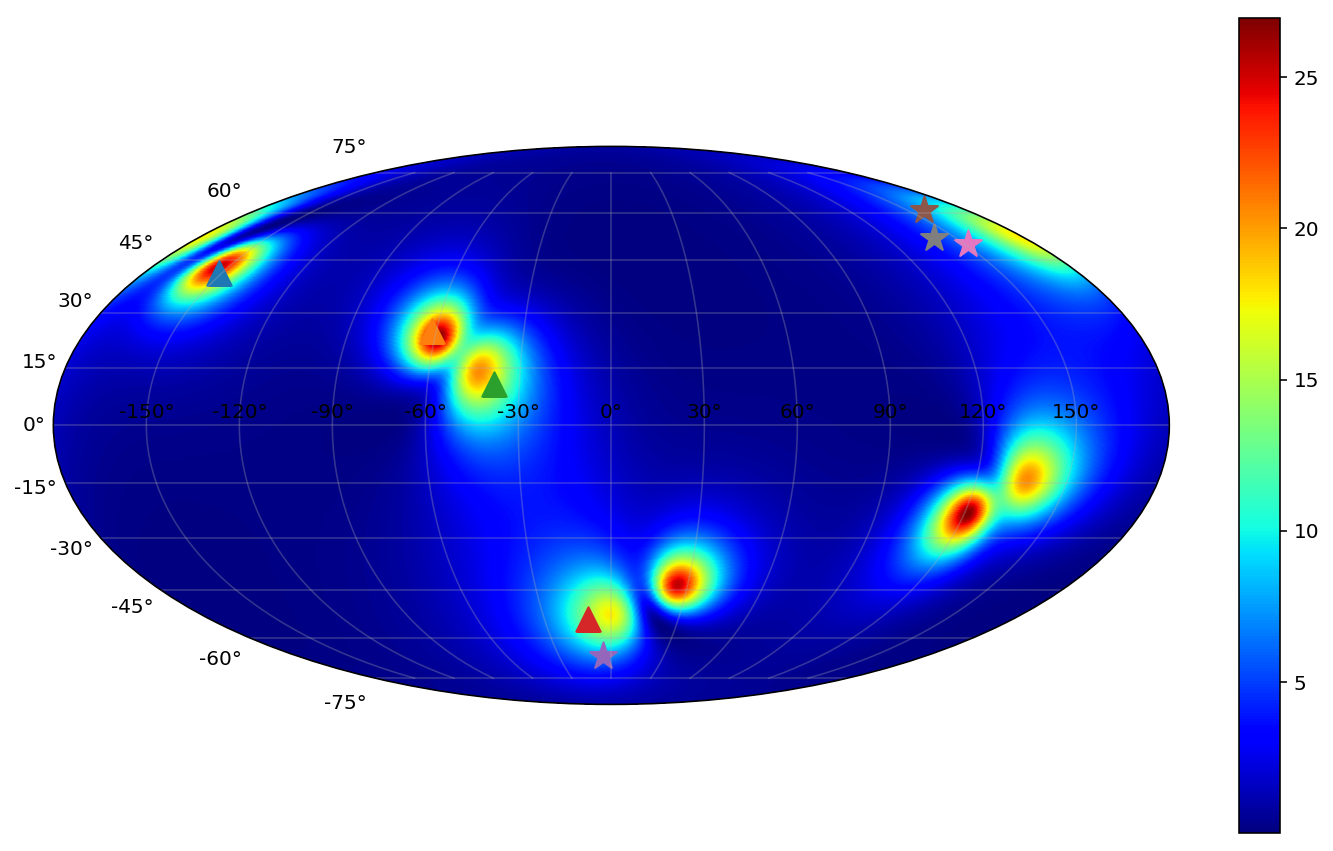

In [20]:
fig = plt.figure(10)
ax = fig.add_subplot(111, projection='mollweide')
fig.set_size_inches(12.5, 7.5)
plt.pcolormesh(ra_mesh, dec_mesh, (1-epsilon_abs**2)/sigma_d, cmap = cm.jet)
plt.colorbar()

#events to minimize epsilon_d
for i in range(4):
    plt.scatter(ra_min_epsilon[i], dec_min_epsilon[i], marker = '^', s = 150)

#events with xi
ra_xi_epsilon = [-0.08395106, 2.77204227, 2.64510923,2.45470968]
dec_xi_epsilon = [-1.15826395814,1.06306418076,0.872664625997,0.904397885124]

for i in range(4):
    plt.scatter(ra_xi_epsilon[i], dec_xi_epsilon[i], marker = '*', s = 200)
    

plt.grid(alpha=0.3)
plt.show()

In [21]:
#Convert coordinates to indizes
def convert(ra, dec):
    
    indra = n*(np.pi+ra)/(2*np.pi)
    inddec = n*(np.pi/2+dec)/np.pi
        
    return int(indra), int(inddec)

#Calculate epsilon_D for all injected events found with xi - Cross check
indra0, inddec0 = convert(realeventra,realeventdec)
indra1, inddec1 = convert(-0.08395106, -1.15826395814)
indra2, inddec2 = convert(2.77204227 ,1.06306418076)
indra3, inddec3 = convert(2.64510923 , 0.872664625997)
indra4, inddec4 = convert(2.45470968,0.904397885124)


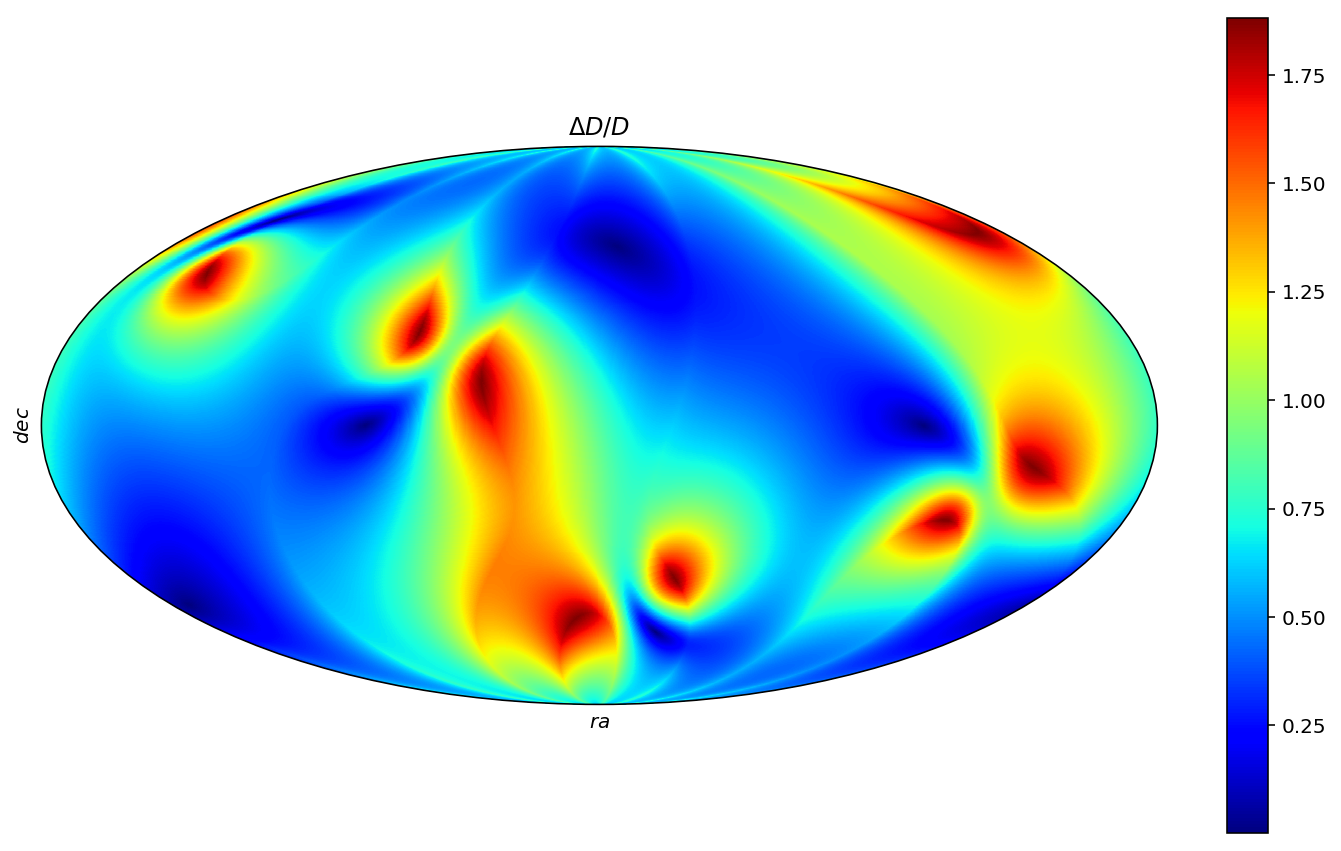

In [36]:
#Mimimize deltaD/D

def deltaDoverD(v, psi, delta_psi, epsilon):
    deltaDoverD_val = np.sqrt((1+v**2-epsilon*np.cos(4*(delta_psi+psi))*(1-v**2))/((1-epsilon**2)*(1-v**2)**2))
    return deltaDoverD_val

deltaDoverD = deltaDoverD(140*np.pi/180, 0, delta_psi, epsilon_abs)

#high_values = deltaDoverD > 1
#deltaDoverD[high_values] = 0

fig = plt.figure(3)
ax = fig.add_subplot(111, projection='mollweide')
fig.set_size_inches(12.5, 7.5)
plt.pcolormesh(ra_mesh, dec_mesh, deltaDoverD**(-1), cmap = cm.jet)
plt.colorbar()

plt.xticks([])
plt.yticks([])
plt.xlabel('$ra$')
plt.ylabel('$dec$')
plt.title('$\Delta D/D$')
plt.show()